# Chapter 9 Exercises

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Use all exogenous variables in a SARIMAX model to predict the real GDP
In this chapter we limited the number of exogenous variables when forecasting for
the real GDP. This exercise is an occasion to fit a SARIMAX model using all exogenous variables and to verify if you can achieve better performance.
1. Use all exogenous variables in the SARIMAX model.
2. Perform residual analysis.
3. Produce forecasts for the last seven timesteps in the dataset.
4. Measure the MAPE. Is it better, worse, or identical to what was achieved with a
limited number of exogenous variables?

In [4]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


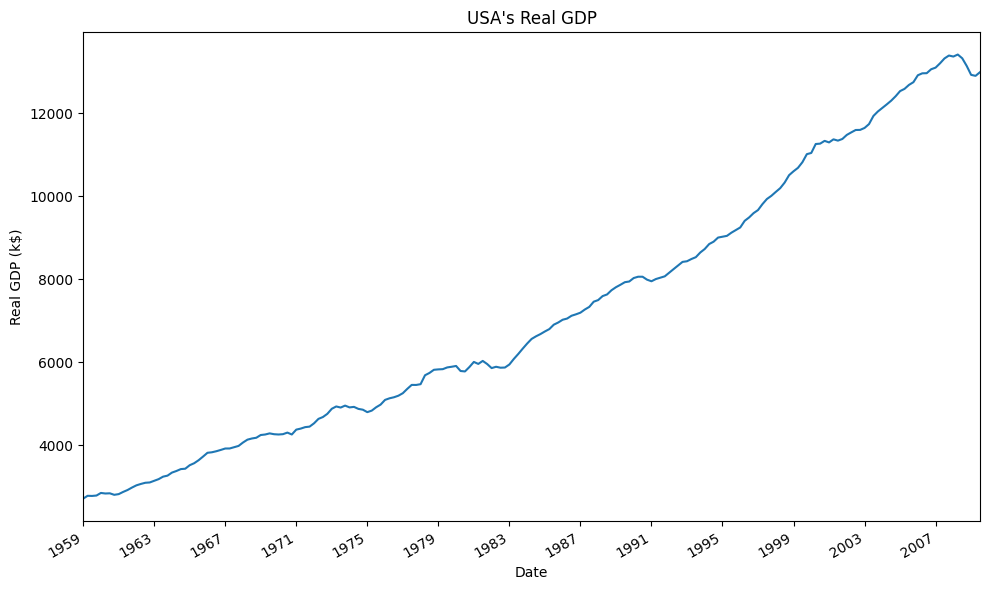

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')
ax.set_title("USA's Real GDP")

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
ax.set_xlim(0, 202) 

fig.autofmt_xdate()
plt.tight_layout()

#### 1. Use all exogenous variables in the SARIMAX model.

In [7]:
# Define the target variable
target = macro_econ_data['realgdp']

# Define the exogenous variables
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 
                        'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

Let's perform ADT Test:

In [9]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(target)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 1.750462796764709
p-value: 0.9982455372335032

p-value > alpha; H0: Not Stationary


The series is not stationary. Let's apply differencing.

In [11]:
# Compute the difference of the target series to make it stationary (differencing)
target_diff = target.diff() #<==== Difference the series

ad_fuller_result1 = adfuller(target_diff[1:]) # ADF test starting from the second element

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08

p-value < alpha; Ha: Stationary


    The series is Stationary. Therefore d=1, D=0, and m=4

In [13]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog, #<==== Exogenous variables
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)

d = 1  #<==== Number of derivatives until Stationy
D = 0  #<==== No seasonality
s = 4  #<==== 4 inputs by year

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [15]:
target_train = target[:200] # The first 200 points of the target is assigned to the target_train set
exog_train = exog[:200]     # The first 200 points of the exog is assigned to the exog_train set

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 0)",1757.066559
1,"(3, 3, 0, 0)",1757.784404
2,"(2, 2, 0, 2)",1758.330388
3,"(2, 2, 0, 0)",1759.088619
4,"(2, 2, 2, 0)",1759.509958
...,...,...
251,"(3, 2, 2, 1)",1776.806687
252,"(3, 2, 1, 3)",1776.867076
253,"(3, 2, 1, 1)",1776.944876
254,"(3, 2, 1, 2)",1778.132128


Best Model:

    non-seasonal order: (p=2, d=1, q=2)
        seasonal order: (P=1, D=0, Q=0, s=4)

    The model with the lowest AIC is a SARIMAX (2,1,2)(1,0,0,4) mode.

#### 2. Perform residual analysis

In [18]:
# Define the SARIMA model with non-seasonal order (p=2, d=1, q=2) and seasonal order (P=1, D=0, Q=0, s=4)
best_model = SARIMAX(target_train, exog_train, order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)

# Fit the model
best_model_fit = best_model.fit(disp=False)  

# Display Summary
best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.533
Date:                            Tue, 18 Feb 2025   AIC                           1757.067
Time:                                    14:45:00   BIC                           1813.053
Sample:                                         0   HQIC                          1779.726
                                            - 200                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9561      0.054     17.689      0.000       0.850       1.062
realinv        0.9965      0.042     23.663      0.000       0.914       1.079
realgovt       0.7362      0.139      5.295      0.000       0.464       1.009
realdpi        0.0133      0.024      0.553      0.580      -0.034       0.061
cpi            5.3591      2.062      2.599      0.009       1.317       9.401
m1            -0.0059      0.159     -0.037      0.970      -0.318       0.307
tbilrate      -3.7513     24.163     -0.155      0.877     -51.110      43.607
unemp         -7.9219      5.730     -1.383      0.167     -19.152       3.309
pop            5.7689      7.572      0.762      0.446      -9.072      20.610
infl          -0.6177     24.049     -0.026      0.980     -47.754      46.518
realint       -0.4812     24.004     -0.020      0.984     -47.529      46.566
ar.L1          1.8110      0.054     33.431      0.000       1.705       1.917
ar.L2         -0.8846      0.056    -15.680      0.000      -0.995      -0.774
ma.L1         -1.8078      0.042    -43.504      0.000      -1.889      -1.726
ma.L2          0.9377      0.038     24.508      0.000       0.863       1.013
ar.S.L4        0.0883      0.069      1.280      0.200      -0.047       0.224
sigma2       325.6822     30.036     10.843      0.000     266.814     384.551
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                13.98
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               3.86   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

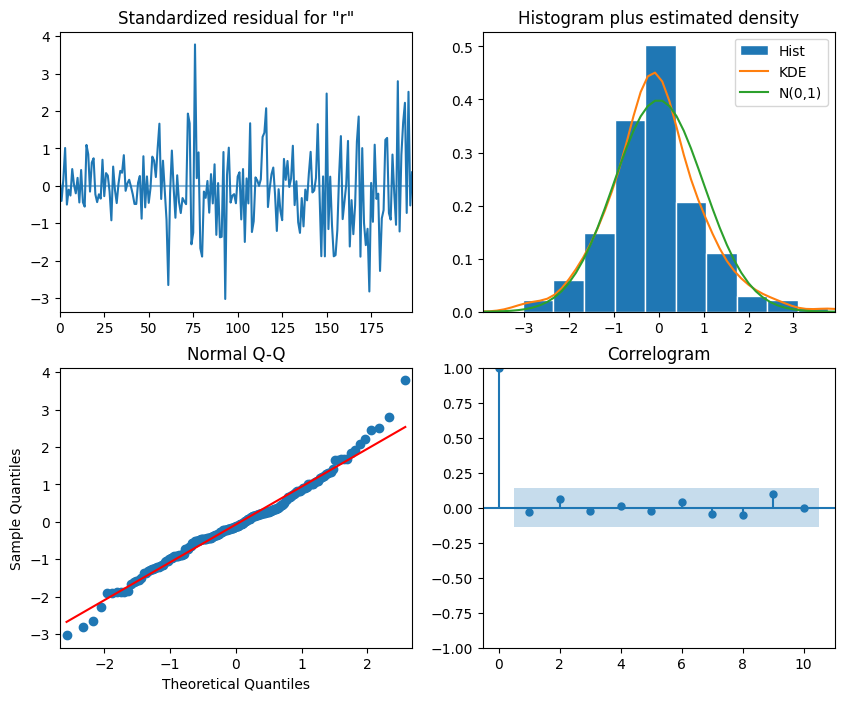

In [19]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8));

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals = best_model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.017498,0.894764
2,0.068427,0.966365
3,0.084582,0.993621
4,0.210197,0.994849
5,0.220661,0.998875
6,0.224746,0.999783
7,0.225255,0.999962
8,0.302934,0.999981
9,0.318728,0.999996
10,0.319158,0.999999


#### 3. Produce forecasts for the last seven timesteps in the dataset.

In [22]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False) #<==== Best Model!
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [23]:
target_train = target[:196]  # First 196 points as target_training
target_test = target[196:]   # Last 7 points (203 - 196) as target_test

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13346.399323
197,13415.266,13366.865,13375.041048
198,13324.600,13415.266,13368.705238
199,13141.920,13324.600,13331.763875
200,12925.410,13141.920,13135.360889
201,12901.504,12925.410,12887.882816
202,12990.341,12901.504,12868.414090


In [24]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
from sklearn.metrics import mean_absolute_error

# Calculate MAPE for each forecast
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

# Display MAPE results
print(f'   MAE for Naive Baseline: {mape_last:.2f}')
print(f' MAE for SARIMAX Forecast: {mape_SARIMAX:.2f}')

   MAE for Naive Baseline: 0.74
 MAE for SARIMAX Forecast: 0.70


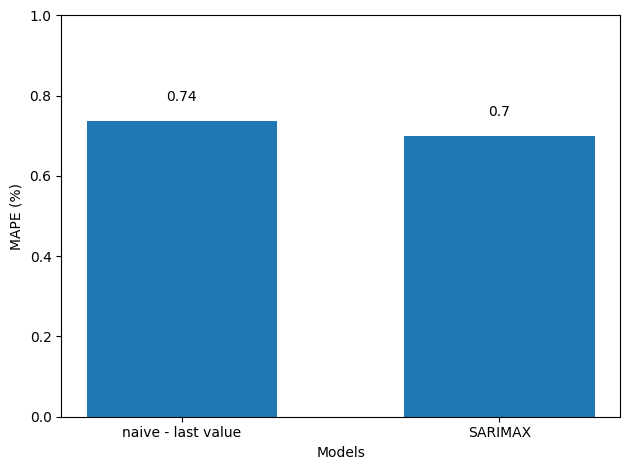

In [26]:
fig, ax = plt.subplots()

x = ['naive - last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

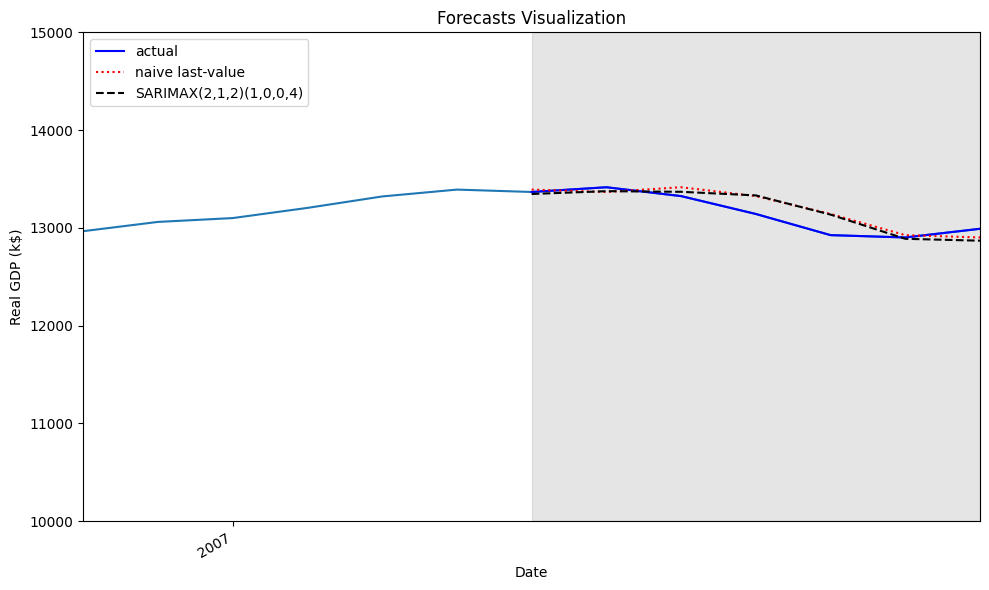

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(macro_econ_data['realgdp'])
ax.plot(pred_df['actual'], 'b-', label='actual')
ax.plot(pred_df['pred_last_value'], 'r:', label='naive last-value')
ax.plot(pred_df['pred_SARIMAX'], 'k--', label='SARIMAX(2,1,2)(1,0,0,4)')
ax.set_title('Forecasts Visualization')

ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')
ax.axvspan(196, 202, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
ax.set_xlim(190, 202)
ax.set_ylim(10000, 15000)

fig.autofmt_xdate()
plt.tight_layout()

In chapter 9, using fewer exogenous variables, we achived a MAPE of 0.7039%. Using all exgogenous variables, we achieved a MAPE of 0.7019%. It is only very slightly better.